In [1]:
from backend import *

In [2]:
# Example usage
group = Group()
john = Person('John Doe', group)
jane = Person('Jane Smith', group)
john.add_undirected_relationship('Jane Smith', 'friends')
john.add_directed_relationship('Hank Doe', 'children')
print(group.relationships, group.people)
group.save_group_to_file('test_people.json')
group2 = Group('test_people.json')
print(group2.relationships, group2.people)

{'friends': 'undirected', 'children': 'directed'} {'John Doe': <backend.Person object at 0x107b78920>, 'Jane Smith': <backend.Person object at 0x107bd7c20>, 'Hank Doe': <backend.Person object at 0x107d4f650>}
{'friends': 'undirected', 'children': 'directed'} {'John Doe': <backend.Person object at 0x107d4fad0>, 'Jane Smith': <backend.Person object at 0x107d4fd40>, 'Hank Doe': <backend.Person object at 0x107d4fce0>}


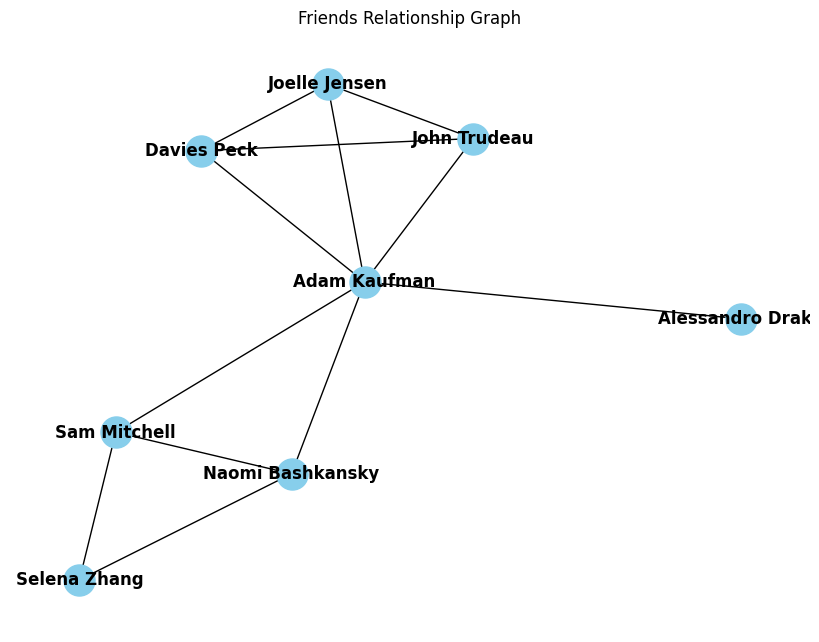

In [3]:
# Example usage
adam_friends = Group()
ghs = ['John Trudeau', 'Joelle Jensen', 'Davies Peck']
ai = ['Sam Mitchell', 'Naomi Bashkansky']
hahvahd = ['Alessandro Drake']
for name in ghs + ai + hahvahd:
    person = Person(name, adam_friends)
    person.add_undirected_relationship('Adam Kaufman', 'friends')

for name in ghs:
    for other_name in ghs:
        if name != other_name:
            adam_friends.people[name].add_undirected_relationship(other_name, 'friends')

selena = Person('Selena Zhang', adam_friends)
for name in ai:
    selena.add_undirected_relationship(name, 'friends')

adam_friends.people['Naomi Bashkansky'].add_undirected_relationship('Sam Mitchell', 'friends')

adam_friends.update_relationship_graphs()
adam_friends.plot_relationship_graph('friends')